In [2]:
import pandas as pd
import numpy as np
from math import floor
from scipy.stats import loguniform
import warnings
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns
#import shap

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score, roc_auc_score

# Data Analysis/Preprocessing

In [3]:
raw_data = pd.read_csv('df_new_features(2).csv')
raw_data = raw_data.drop('Unnamed: 0',axis = 1)
raw_data.head()

,SeasonID,TeamID,Conference,PlayoffRankLag1,WinPCTLag1,DiffPointsPGLag1,LongHomeStreakLag1,LongRoadStreakLag1,PlayoffRankLag2,WinPCTLag2,...,LongRoadStreakLag3,PlayoffRankLag4,WinPCTLag4,DiffPointsPGLag4,LongHomeStreakLag4,LongRoadStreakLag4,isPlayoff,nyt_score,twitter_score,reddit_score
0,2008,1610612739,East,4,0.549,-0.4,9,1,2,0.610,...,4,9,0.512,0.8,9,11,1,0.038036,0.024716,0.223679
1,2008,1610612747,West,1,0.695,7.3,6,7,7,0.512,...,4,11,0.415,-3.0,5,9,1,0.235119,0.070399,0.063052
2,2008,1610612743,West,8,0.610,3.7,9,3,6,0.549,...,4,7,0.598,2.0,12,5,1,0.098203,-0.037116,0.013385
3,2008,1610612738,East,1,0.805,10.3,12,10,15,0.293,...,2,4,0.549,0.9,5,9,1,-0.014583,0.095421,0.112292
4,2008,1610612759,West,3,0.683,4.8,13,5,3,0.707,...,9,2,0.720,7.8,16,6,1,0.086667,0.097475,0.065091


In [4]:
train_data = raw_data.iloc[:-60]
validation_data = raw_data.iloc[-60:-30]
test_data = raw_data.iloc[-30:]

In [5]:
# Split into X and y train
X_train = train_data.drop(['SeasonID','TeamID','isPlayoff'],axis = 1)
y_train = train_data['isPlayoff']

X_val = validation_data.drop(['SeasonID','TeamID','isPlayoff'],axis = 1)
y_val = validation_data['isPlayoff']
X_val = X_val.reset_index().drop('index',axis = 1)
y_val = y_val.reset_index().drop('index',axis = 1)

X_test = test_data.drop(['SeasonID','TeamID','isPlayoff'],axis = 1)
y_test = test_data['isPlayoff']
X_test = X_test.reset_index().drop('index',axis = 1)
y_test = y_test.reset_index().drop('index',axis = 1)

In [6]:
len(X_train), len(y_train) ,len(X_val), len(y_val), len(X_test), len(y_test)

(390, 390, 30, 30, 30, 30)

## One Hot Encode

In [7]:
# Train data
ohe = OneHotEncoder()
encoded_data = ohe.fit_transform(X_train[['Conference']]).toarray()
columns = ohe.get_feature_names(X_train[['Conference']].columns)
train_encoded = pd.DataFrame(encoded_data, columns=columns)

X_train = pd.concat([X_train.drop('Conference',axis=1),train_encoded],axis = 1)

In [8]:
# Validation data
encoded_data = ohe.transform(X_val[['Conference']]).toarray()
columns = ohe.get_feature_names(X_val[['Conference']].columns)
val_encoded = pd.DataFrame(encoded_data, columns=columns)

X_val = pd.concat([X_val.drop('Conference',axis=1),val_encoded],axis = 1)

In [9]:
# Test data
encoded_data = ohe.transform(X_test[['Conference']]).toarray()
columns = ohe.get_feature_names(X_test[['Conference']].columns)
test_encoded = pd.DataFrame(encoded_data, columns=columns)

X_test = pd.concat([X_test.drop('Conference',axis=1),test_encoded],axis = 1)

# Building Models (Round 1: Before Feature Selection)

In [10]:
# Creating time series split
num_obs = len(train_data)
num_per_season = 30
n_splits = int(num_obs/num_per_season - 1)

time_series_split = TimeSeriesSplit(n_splits = n_splits)

## Logistic Regression

In [11]:
warnings.filterwarnings("ignore", message="The max_iter was reached which means the coef_ did not converge")

In [12]:
# Hyperparameter tuning
logreg_param = {'penalty': ['l1','l2'], 'C': loguniform(1e-5, 100), 
                'max_iter': np.arange(2000,5000,300), 'solver': ['liblinear','saga']}

# Scoring metric
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Build the model
logreg = LogisticRegression()
logreg_gridsearch = RandomizedSearchCV(logreg, logreg_param, n_iter = 150, cv = time_series_split, 
                                       random_state=42,scoring = scoring, refit = 'roc_auc',n_jobs = -1)
logreg_gridsearch.fit(X_train, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', logreg_gridsearch.best_params_)

Best hyperparameters: {'C': 6.71666662945818e-05, 'max_iter': 3200, 'penalty': 'l2', 'solver': 'liblinear'}


In [13]:
# Fit to validation set data
best_logreg = logreg_gridsearch.best_estimator_
logreg_pred = best_logreg.predict(X_val)
logreg_probs = best_logreg.predict_proba(X_val)[:,1]

metrics = ['f1-score','Accuracy','Recall','Precision','ROC-AUC']

logreg_f1, logreg_accuracy = f1_score(y_val,logreg_pred), accuracy_score(y_val,logreg_pred)
logreg_recall, logreg_precision = recall_score(y_val,logreg_pred), precision_score(y_val,logreg_pred)
logreg_auc = roc_auc_score(y_val,logreg_probs)

logreg_metrics = pd.DataFrame([logreg_f1, logreg_accuracy, logreg_recall, logreg_precision, logreg_auc], 
                              index = metrics)
logreg_metrics

,0
f1-score,0.709677
Accuracy,0.700000
Recall,0.687500
Precision,0.733333
ROC-AUC,0.727679


## Support Vector Machine

In [14]:
# Hyperparameter tuning
svc_param = {'C': loguniform(1e-3, 1e2), 'gamma': np.arange(0.0001,0.1,0.04), 
             'kernel': ['linear', 'rbf'], 'probability': [True]}

# Build the model
svc = SVC()
svc_gridsearch = RandomizedSearchCV(svc, svc_param, n_iter = 150, cv = time_series_split, 
                                    random_state=42,scoring = scoring, refit = 'roc_auc',n_jobs = -1)
svc_gridsearch.fit(X_train, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', svc_gridsearch.best_params_)

Best hyperparameters: {'C': 1.9411739809629627, 'gamma': 0.0001, 'kernel': 'rbf', 'probability': True}


In [15]:
# Fit to validation set data
best_svc = svc_gridsearch.best_estimator_
svc_pred = best_svc.predict(X_val)
svc_probs = best_svc.predict_proba(X_val)[:,1]

svc_f1, svc_accuracy = f1_score(y_val,svc_pred), accuracy_score(y_val,svc_pred)
svc_recall, svc_precision = recall_score(y_val,svc_pred), precision_score(y_val,svc_pred)
svc_auc = roc_auc_score(y_val,svc_probs)

svc_metrics = pd.DataFrame([svc_f1, svc_accuracy, svc_recall, svc_precision, svc_auc], 
                              index = metrics)
svc_metrics

,0
f1-score,0.687500
Accuracy,0.666667
Recall,0.687500
Precision,0.687500
ROC-AUC,0.758929


## AdaBoost

In [16]:
# Hyperparameter tuning
adaboost_param = {'n_estimators': np.arange(50,500,30), 'learning_rate': loguniform(0.01, 0.99)}

# Build the model
adaboost = AdaBoostClassifier()
adaboost_gridsearch = RandomizedSearchCV(adaboost, adaboost_param, n_iter = 150, cv = time_series_split, 
                                        random_state=42,scoring = scoring, refit = 'roc_auc', n_jobs = -1)
adaboost_gridsearch.fit(X_train, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', adaboost_gridsearch.best_params_)

Best hyperparameters: {'learning_rate': 0.017524394419731543, 'n_estimators': 290}


In [17]:
# Fit to validation set data
best_adaboost = adaboost_gridsearch.best_estimator_
adaboost_pred = best_adaboost.predict(X_val)
adaboost_probs = best_adaboost.predict_proba(X_val)[:,1]

adaboost_f1, adaboost_accuracy = f1_score(y_val,adaboost_pred), accuracy_score(y_val,adaboost_pred)
adaboost_recall, adaboost_precision = recall_score(y_val,adaboost_pred), precision_score(y_val,adaboost_pred)
adaboost_auc = roc_auc_score(y_val,adaboost_probs)

adaboost_metrics = pd.DataFrame([adaboost_f1, adaboost_accuracy, adaboost_recall, adaboost_precision, 
                                 adaboost_auc], index = metrics)
adaboost_metrics

,0
f1-score,0.628571
Accuracy,0.566667
Recall,0.687500
Precision,0.578947
ROC-AUC,0.720982


## Gradient Boosting

In [18]:
# Hyperparameter tuning
xgb_param = {'learning_rate': loguniform(0.01, 0.99), 'n_estimators': np.arange(100,800,100), 
             'max_depth': np.arange(2,13,2), 'gamma': loguniform(0.01, 0.99)}

# Build the model
xgb = XGBClassifier()
xgb_gridsearch = RandomizedSearchCV(xgb, xgb_param, n_iter = 150, cv = time_series_split, random_state=42, 
                                    scoring = scoring,refit = 'roc_auc', n_jobs = -1)
xgb_gridsearch.fit(X_train, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', xgb_gridsearch.best_params_)

Best hyperparameters: {'gamma': 0.5377899877379935, 'learning_rate': 0.18622132698142577, 'max_depth': 8, 'n_estimators': 400}


In [19]:
# Fit to validation set data
best_xgb = xgb_gridsearch.best_estimator_
xgb_pred = best_xgb.predict(X_val)
xgb_probs = best_xgb.predict_proba(X_val)[:,1]

xgb_f1, xgb_accuracy = f1_score(y_val,xgb_pred), accuracy_score(y_val,xgb_pred)
xgb_recall, xgb_precision = recall_score(y_val,xgb_pred), precision_score(y_val,xgb_pred)
xgb_auc = roc_auc_score(y_val,xgb_probs)

xgb_metrics = pd.DataFrame([xgb_f1, xgb_accuracy, xgb_recall, xgb_precision, 
                                 xgb_auc], index = metrics)
xgb_metrics

,0
f1-score,0.727273
Accuracy,0.700000
Recall,0.750000
Precision,0.705882
ROC-AUC,0.687500


## Random Forest

In [20]:
# Hyperparameter tuning
rf_param = {'n_estimators': np.arange(50,300,50), 'criterion':['gini', 'entropy'],'max_depth': np.arange(2,10,2),
            'min_samples_split': np.arange(10,30,5),'max_features': ['sqrt', 'log2', None]}

# Build the model
rf = RandomForestClassifier()
rf_gridsearch = RandomizedSearchCV(rf, rf_param, n_iter = 150, cv = time_series_split, random_state=42, 
                                   scoring = scoring, refit = 'roc_auc', n_jobs = -1)
rf_gridsearch.fit(X_train, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', rf_gridsearch.best_params_)

Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 15, 'max_features': 'sqrt', 'max_depth': 2, 'criterion': 'entropy'}


In [21]:
# Fit to validation set data
best_rf = rf_gridsearch.best_estimator_
rf_pred = best_rf.predict(X_val)
rf_probs = best_rf.predict_proba(X_val)[:,1]

rf_f1, rf_accuracy = f1_score(y_val,rf_pred), accuracy_score(y_val,rf_pred)
rf_recall, rf_precision = recall_score(y_val,rf_pred), precision_score(y_val,rf_pred)
rf_auc = roc_auc_score(y_val,rf_probs)

rf_metrics = pd.DataFrame([rf_f1, rf_accuracy, rf_recall, rf_precision, 
                                 rf_auc], index = metrics)
rf_metrics

,0
f1-score,0.687500
Accuracy,0.666667
Recall,0.687500
Precision,0.687500
ROC-AUC,0.709821


# Naive Bayes

In [22]:
# We use Gaussian Naive Bayes because of the nature of our features being mostly continuous

# Hyperparameter tuning
gnb_param = {'var_smoothing': loguniform(1e-10, 1e-3)}

# Build the model
gnb = GaussianNB()
gnb_gridsearch = RandomizedSearchCV(gnb, gnb_param, n_iter = 150, cv = time_series_split, random_state=42, 
                                    scoring = scoring,refit = 'roc_auc', n_jobs = -1)
gnb_gridsearch.fit(X_train, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', gnb_gridsearch.best_params_)

Best hyperparameters: {'var_smoothing': 0.00011567327199145978}


In [23]:
# Fit to validation set data
best_gnb = gnb_gridsearch.best_estimator_
gnb_pred = best_gnb.predict(X_val)
gnb_probs = best_gnb.predict_proba(X_val)[:,1]

gnb_f1, gnb_accuracy = f1_score(y_val,gnb_pred), accuracy_score(y_val,gnb_pred)
gnb_recall, gnb_precision = recall_score(y_val,gnb_pred), precision_score(y_val,gnb_pred)
gnb_auc = roc_auc_score(y_val,gnb_probs)

gnb_metrics = pd.DataFrame([gnb_f1, gnb_accuracy, gnb_recall, gnb_precision, 
                                 gnb_auc], index = metrics)
gnb_metrics

,0
f1-score,0.645161
Accuracy,0.633333
Recall,0.625000
Precision,0.666667
ROC-AUC,0.745536


# Neural Networks

In [24]:
# Hyperparameter tuning
mlp_param = {'hidden_layer_sizes': [(10,), (50,), (100,), (10,10), (50,50), (100,100)],
             'activation': ['relu', 'logistic', 'tanh'], 'solver': ['adam', 'lbfgs', 'sgd'],
             'alpha': loguniform(1e-3, 1e0),'learning_rate': ['constant', 'adaptive']
}

# Build the model
mlp = MLPClassifier(max_iter = 10000)
mlp_gridsearch = RandomizedSearchCV(mlp, mlp_param, n_iter = 150, cv = time_series_split, random_state=42, 
                                    scoring = scoring,refit = 'roc_auc', n_jobs = -1)
mlp_gridsearch.fit(X_train, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', mlp_gridsearch.best_params_)

Best hyperparameters: {'activation': 'logistic', 'alpha': 0.01572075238793222, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'sgd'}


In [25]:
# Fit to validation set data
best_mlp = mlp_gridsearch.best_estimator_
mlp_pred = best_mlp.predict(X_val)
mlp_probs = best_mlp.predict_proba(X_val)[:,1]

mlp_f1, mlp_accuracy = f1_score(y_val,mlp_pred), accuracy_score(y_val,mlp_pred)
mlp_recall, mlp_precision = recall_score(y_val,mlp_pred), precision_score(y_val,mlp_pred)
mlp_auc = roc_auc_score(y_val,mlp_probs)

mlp_metrics = pd.DataFrame([mlp_f1, mlp_accuracy, mlp_recall, mlp_precision, 
                                 mlp_auc], index = metrics)
mlp_metrics

,0
f1-score,0.733333
Accuracy,0.733333
Recall,0.687500
Precision,0.785714
ROC-AUC,0.745536


## Summary of Models' Performance

In [26]:
combined_metrics = pd.concat([logreg_metrics, svc_metrics, adaboost_metrics, xgb_metrics,rf_metrics,gnb_metrics,
                              mlp_metrics], axis = 1)
combined_metrics.columns = ['Logistic Regression','Support Vector Machine','AdaBoost',
                            'Extreme Gradient Boosting','Random Forest', 'Gaussian Naive Bayes',
                            'Multi-layer Perceptron classifier']
combined_metrics

,Logistic Regression,Support Vector Machine,AdaBoost,Extreme Gradient Boosting,Random Forest,Gaussian Naive Bayes,Multi-layer Perceptron classifier
f1-score,0.709677,0.687500,0.628571,0.727273,0.687500,0.645161,0.733333
Accuracy,0.700000,0.666667,0.566667,0.700000,0.666667,0.633333,0.733333
Recall,0.687500,0.687500,0.687500,0.750000,0.687500,0.625000,0.687500
Precision,0.733333,0.687500,0.578947,0.705882,0.687500,0.666667,0.785714
ROC-AUC,0.727679,0.758929,0.720982,0.687500,0.709821,0.745536,0.745536


# Model Evaluation (Round 1: Before Feature Selection)

## Correlation Matrix

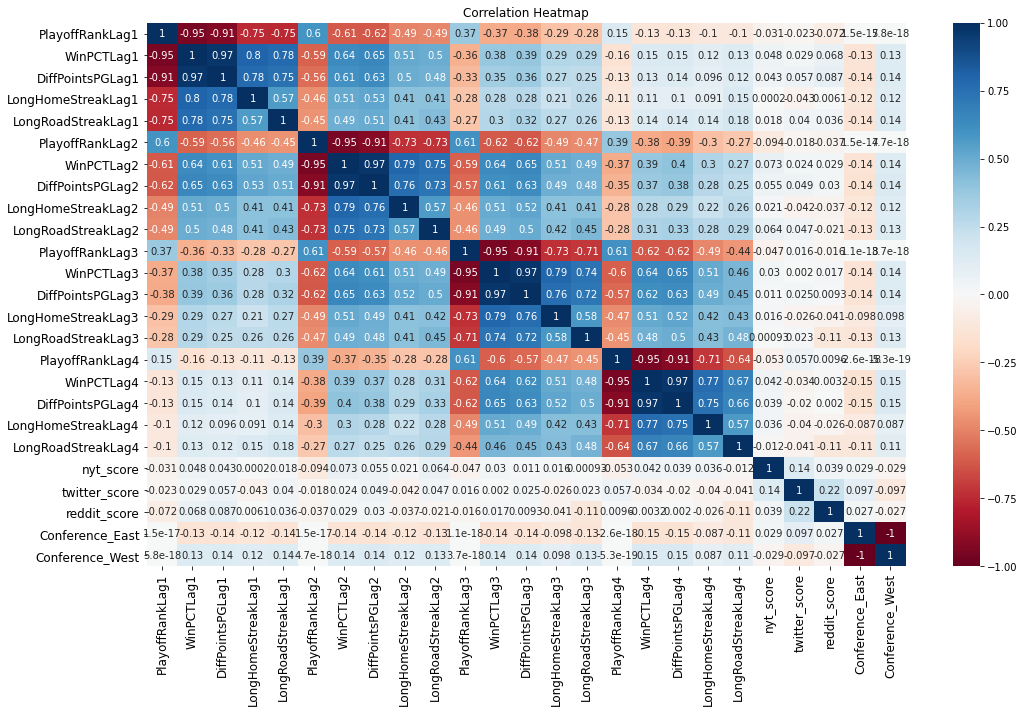

In [27]:
plt.figure(figsize = (17,10))
s = sns.heatmap(X_train.corr(),
             annot = True,
             cmap = 'RdBu',
             vmin = -1,
             vmax= 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

## Feature Importance from Non-Linear Models

We use SHAP values to find out which features are important for each of the non-linear models. Our intention is to compare correlated features from above and keep those that are more important.

In [72]:
# Support Vector Machine

svc_explainer = shap.KernelExplainer(best_svc.predict_proba, X_train)
svc_shap = svc_explainer(X_val)

shap.summary_plot(svc_shap, plot_type='violin')

Using 390 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


AttributeError: 'Kernel' object has no attribute 'masker'

In [59]:
# Adaboost

adaboost_explainer = shap.KernelExplainer(best_adaboost, X_train)
adaboost_shap = adaboost_explainer(X_val)

shap.summary_plot(adaboost_shap, plot_type='violin')

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>

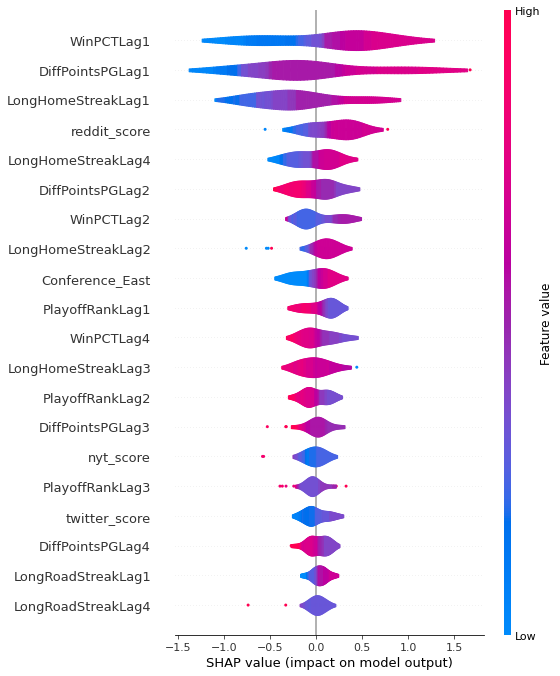

In [62]:
# Extreme Gradient Boosting

xgb_explainer = shap.TreeExplainer(best_xgb, X_train)
xgb_shap = xgb_explainer(X_val)

shap.summary_plot(xgb_shap, plot_type='violin')

TypeError: only integer scalar arrays can be converted to a scalar index

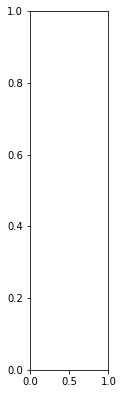

In [75]:
# Random Forest

rf_explainer = shap.TreeExplainer(best_rf, X_train)
rf_shap = rf_explainer(X_val)

shap.summary_plot(rf_shap, plot_type='violin')

In [76]:
# Multi-layer Perceptron classifier

mlp_explainer = shap.DeepExplainer(best_mlp, X_train)
mlp_shap = mlp_explainer(X_val)

shap.summary_plot(mlp_shap, plot_type='violin')

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


AssertionError: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'> is not currently a supported model type!

# Model Evaluation (Round 2: After Feature Selection)

In [150]:
X_train = X_train.drop(['PlayoffRankLag1','PlayoffRankLag2','PlayoffRankLag3','PlayoffRankLag4',
                        'DiffPointsPGLag1','DiffPointsPGLag2','DiffPointsPGLag3','DiffPointsPGLag4',
                       'Conference_West'],axis = 1)

## Logistic Regression

In [ ]:
# Hyperparameter tuning
logreg_final_param = {'penalty': ['l1','l2'], 'C': loguniform(1e-5, 100), 
                'max_iter': np.arange(2000,5000,300), 'solver': ['liblinear','saga']}

# Scoring metric
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Build the model
logreg_final = LogisticRegression()
logreg_final_gridsearch = RandomizedSearchCV(logreg_final, logreg_final_param, n_iter = 150, 
                                             cv = time_series_split, random_state=42,scoring = scoring, 
                                             refit = 'f1',n_jobs = -1)
logreg_final_gridsearch.fit(X_train, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', logreg_final_gridsearch.best_params_)

In [ ]:
# Fit to validation set data
best_logreg_final = logreg_final_gridsearch.best_estimator_
logreg_pred_final = best_logreg_final.predict(X_val)
logreg_probs_final = best_logreg_final.predict_proba(X_val)[:,1]

logreg_final_f1,logreg_final_accuracy = f1_score(y_val,logreg_pred_final), accuracy_score(y_val,logreg_pred_final)
logreg_final_recall = recall_score(y_val,logreg_pred_final)
logreg_final_precision = precision_score(y_val,logreg_pred_final)
logreg_final_auc = roc_auc_score(y_val,logreg_pred_final)

logreg_final_metrics = pd.DataFrame([logreg_final_f1, logreg_final_accuracy, logreg_final_recall, 
                                     logreg_final_precision, logreg_final_auc], index = metrics)
logreg_final_metrics

## Naive Bayes

In [ ]:
# We use Gaussian Naive Bayes because of the nature of our features being mostly continuous

# Hyperparameter tuning
gnb_final_param = {'var_smoothing': loguniform(1e-10, 1e-3)}

# Build the model
gnb_final = GaussianNB()
gnb_final_gridsearch = RandomizedSearchCV(gnb_final, gnb_final_param, n_iter = 150, cv = time_series_split, 
                                          random_state=42, scoring = scoring,refit = 'f1', n_jobs = -1)
gnb_final_gridsearch.fit(X_train, y_train)

# Find the best hyperparameters
print('Best hyperparameters:', gnb_final_gridsearch.best_params_)

In [ ]:
# Fit to validation set data
best_gnb_final = gnb_final_gridsearch.best_estimator_
gnb_pred_final = best_gnb_final.predict(X_val)
gnb_probs_final = best_gnb_final.predict_proba(X_val)[:,1]

gnb_final_f1, gnb_final_accuracy = f1_score(y_val,gnb_pred_final), accuracy_score(y_val,gnb_pred_final)
gnb_final_recall, gnb_final_precision = recall_score(y_val,gnb_pred_final), precision_score(y_val,gnb_pred_final)
gnb_final_auc = roc_auc_score(y_val,gnb_pred_final)

gnb_final_metrics = pd.DataFrame([gnb_final_f1, gnb_final_accuracy, gnb_final_recall, gnb_final_precision, 
                                 gnb_final_auc], index = metrics)
gnb_final_metrics

## Comparison of Models' Performance 

In [ ]:
metrics = pd.concat([logreg_metrics, logreg_final_metrics, gnb_metrics, gnb_final_metrics],axis = 1)
metrics.columns = ['Logistic Regression (Before)','Logistic Regression (After)',
                   'Gaussian Naive Bayes (Before)','Gaussian Naive Bayes (After)']
metrics

# Using the Chosen Model on the Test Set

In [49]:
# Get the other metrics for the best model

# Since only 16 teams can make it into the playoffs, we take the top 16 teams using the predict probability 
# function, there must also be 8 teams from each region

# Get probabilities of making it to the Playoffs from the best hyperparameters
logreg_final = LogisticRegression(C = 0.00022904334341315342, max_iter = 4100, penalty = 'l2', solver = 'saga')
logreg_final.fit(X_train, y_train)
logreg_y_probs = logreg_final.predict_proba(X_test)[:,1]

# Combine the probabilities with the initial full dataframe
test_data = test_data.reset_index().drop('index',axis = 1)
logreg_combined = pd.concat([test_data,pd.DataFrame(logreg_y_probs,columns = ['prob'])],axis = 1)

# Input class labels for each team in each season based on the ranking of probabilties. The top 8 teams for each
# season and each region will be labelled as 1 while the others will be labelled as 0

logreg_classone = logreg_combined.sort_values('prob',ascending=False).groupby(['SeasonID','Conference']).head(8)
logreg_combined['predicted_class'] = 0
logreg_combined.loc[logreg_classone.index, 'predicted_class'] = 1
logreg_y_pred = logreg_combined['predicted_class']

metrics = ['f1-score','Accuracy','Recall','Precision','ROC-AUC']

logreg_f1, logreg_accuracy = f1_score(y_test,logreg_y_pred), accuracy_score(y_test,logreg_y_pred)
logreg_recall, logreg_precision = recall_score(y_test,logreg_y_pred), precision_score(y_test,logreg_y_pred)
logreg_auc = roc_auc_score(y_test,logreg_y_probs)

logreg_metrics = pd.DataFrame([logreg_f1, logreg_accuracy, logreg_recall, logreg_precision, logreg_auc], 
                              index = metrics)
logreg_metrics

,0
f1-score,0.687500
Accuracy,0.666667
Recall,0.687500
Precision,0.687500
ROC-AUC,0.750000
